# Segmentation CNN

Here we are training a CNN to recognize if a letter is in the center of a 32x32 image. This will be used to locate letters in multi char CAPTCHAs

We have a dataset of 32x32 captcha images with one char, labeled if the char is in the middle or not. 

x : (468,000, 32, 32, 3)
y : (468,000, )  0 for uncentered, 1 otherwise

First we will preprocess the data. Our images are black and white, so we will colapse down to 1 color chanel. We will also normalize, shuffle, and make trainging splits

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import image_preprocess

# Automatically reload your external source code
%load_ext autoreload
%autoreload 2

In [2]:
#Make sure at least one of these files exist
#Path to full data files created by Data Gen Notebook
X_PATH = "data/x_single.npy"
Y_PATH = "data/y_single_pos.npy"

#Preprocessed and saved previously
X_PREPROCESSED = "data/x_single_preprocessed.npy"
Y_PREPROCESSED = "data/y_single_pos_preprocessed.npy"

#Smaller data set for development
X_DEV = "data/x_single_dev.npy"
Y_DEV = "data/y_single_pos_dev.npy"

USE_DEV = True


if not os.path.exists(X_PREPROCESSED):
    print("Preprocessing data, please wait...")
    image_preprocess.preprocess_image_data(X_PATH, Y_PATH)
    print("Preprocessed data saved to disk")
    
if not USE_DEV:
    print("Loading in preprocessed data")
    print("Creating Splits")
    x_train, x_val, x_test, x_train_dev, x_val_dev,  y_train, y_val, y_test, y_train_dev, y_val_dev =  image_preprocess.split(X_PREPROCESSED, Y_PREPROCESSED)

if USE_DEV:
    print("Loading in dev set")
    print("Creating splits")
    x_train, x_val, x_test, x_train_dev, x_val_dev, y_train, y_val, y_test, y_train_dev, y_val_dev =  image_preprocess.split(X_DEV, Y_DEV)

Loading in dev set
Creating splits


In [5]:
#Setting up dev data if needed
USE_DEV = True

if USE_DEV and not os.path.exists(X_DEV):
    x_dev = x_train[:10000,:,:,:]
    y_dev = y_train[:10000,:,:,:]
    np.save(X_DEV, x_dev)
    np.save(Y_DEV, y_dev)
    x_train, x_val, x_test, x_train_dev, x_val_dev, y_train, y_val, y_test, y_train_dev, y_val_dev =  image_preprocess.split(X_DEV, Y_DEV)

Training Data Shape: (20000, 32, 32, 1)
Validation Data Shape: (2000, 32, 32, 1)


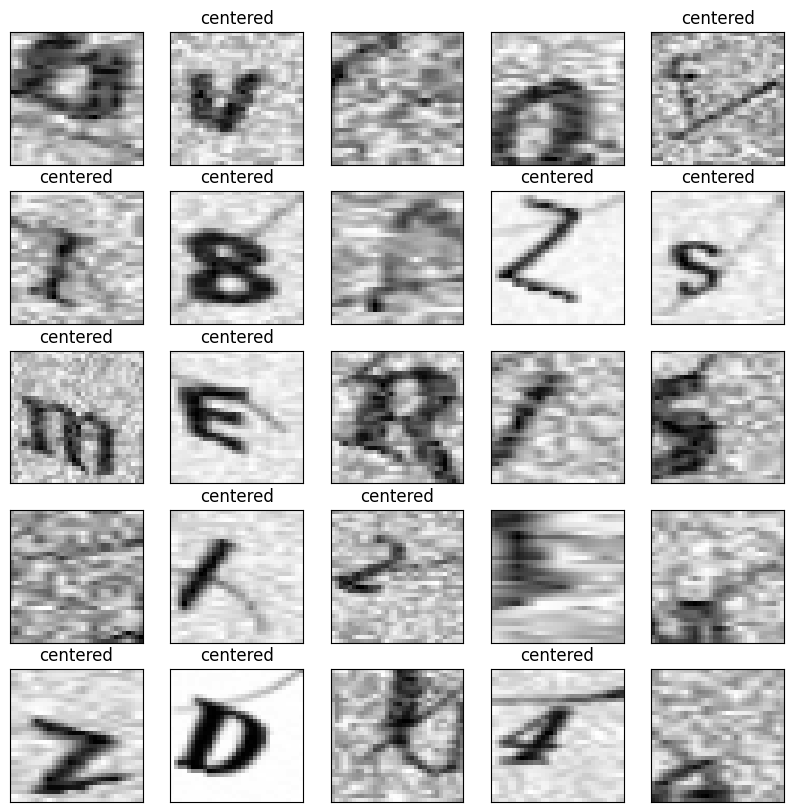

In [3]:
#Data Validation
print(f"Training Data Shape: {x_train.shape}")
print(f"Validation Data Shape: {x_val.shape}")

#Plots 25 random training samples
fig, axs = plt.subplots(5,5)
N = x_train.shape[0]
fig.set_size_inches(10,10)
for i in range(5):
    for j in range(5):
        ax = axs[i,j]
        idx = np.random.randint(N)
        ax.imshow((x_train[idx,:,:]), cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        title = "centered" if y_train[idx] == 1 else ""
        ax.set_title(title)
plt.show()

In [4]:
#Testing on full size images
#Loading in with imgage_preprocess.py
import image_preprocess
import os


if not os.path.exists("data/x_multi_preprocessed.npy") and not os.path.exists("data/y_multi_preprocessed.npy"):
    print("Preprocessing data...")
    image_preprocess.preprocess_image_data("data/x_multi.npy", "data/y_multi.npy")
    print("Preprocessed data saved to disk")

x_multi = np.load("data/x_multi_preprocessed.npy")
y_multi = np.load("data/y_multi_preprocessed.npy")

print(f"Loaded in images, x.shape = {x_multi.shape}")

Loaded in images, x.shape = (23400, 72, 200, 1)


In [5]:
#Getting test data
x_multi = x_multi[:1000, :, :]
y_multi = y_multi[:1000]
print(x_multi.shape)
print(y_multi.shape)

(1000, 72, 200, 1)
(1000,)


# CNN Training

Using tensor flow model here. Following this tutorial:https://www.tensorflow.org/tutorials/images/cnn

Epoch 1/5
200/200 [==============================] - 3s 10ms/step - loss: 0.3329 - accuracy: 0.8482 - val_loss: 0.1318 - val_accuracy: 0.9555
Epoch 2/5
200/200 [==============================] - 2s 10ms/step - loss: 0.1158 - accuracy: 0.9569 - val_loss: 0.1032 - val_accuracy: 0.9540
Epoch 3/5
200/200 [==============================] - 2s 10ms/step - loss: 0.0768 - accuracy: 0.9712 - val_loss: 0.0705 - val_accuracy: 0.9775
Epoch 4/5
200/200 [==============================] - 2s 9ms/step - loss: 0.0635 - accuracy: 0.9776 - val_loss: 0.0550 - val_accuracy: 0.9780
Epoch 5/5
200/200 [==============================] - 2s 10ms/step - loss: 0.0559 - accuracy: 0.9783 - val_loss: 0.0509 - val_accuracy: 0.9835


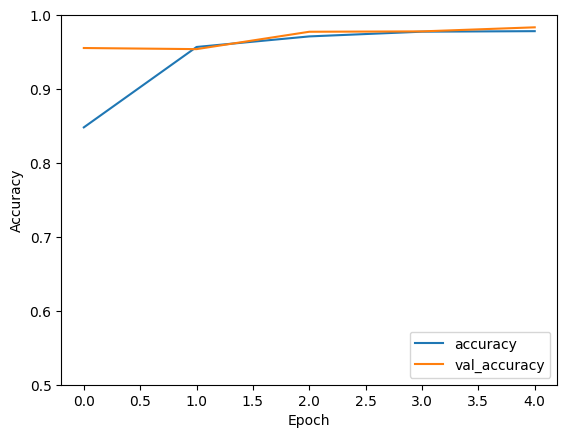

In [12]:
from locator import Locator_Net

lr = 0.0015
mini_batch = 100 #32
epochs = 5 #10

segnet = Locator_Net(lr=lr)
history = segnet.train(x_train, y_train, x_val, y_val, batch_size=mini_batch, epochs = epochs)


#Plotting Training Data
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')







Scanning Image...: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 18.80it/s]
/tmp/ipykernel_42252/2760261608.py:21: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
Scanning Image...: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 16.73it/s]


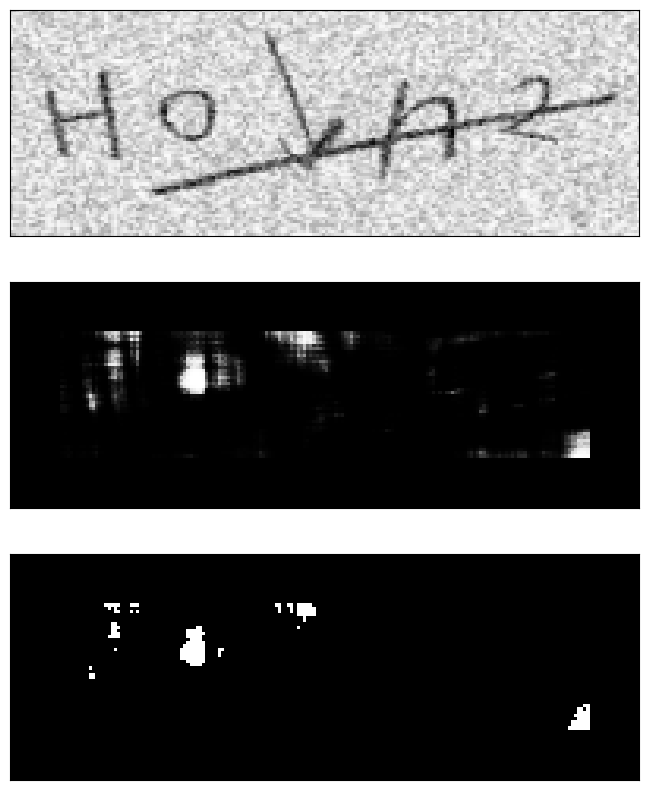

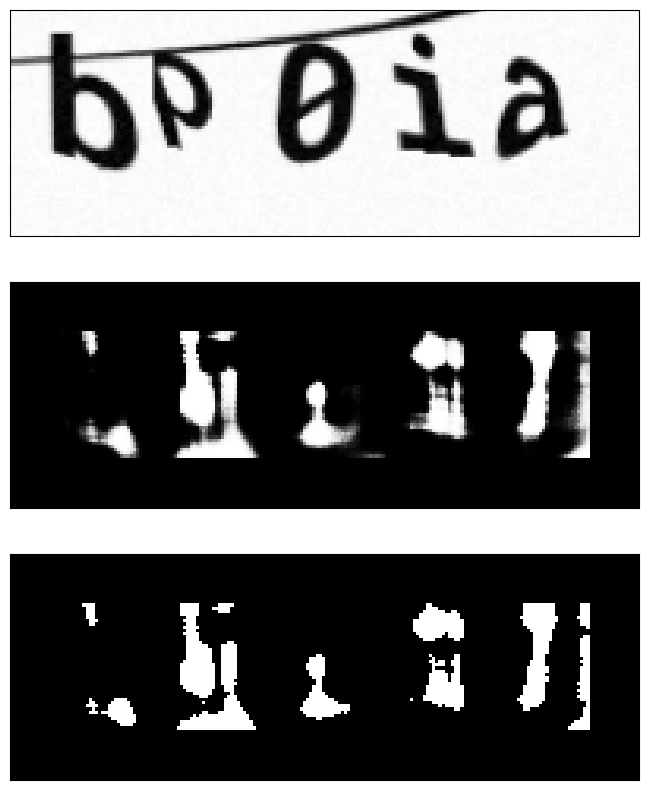

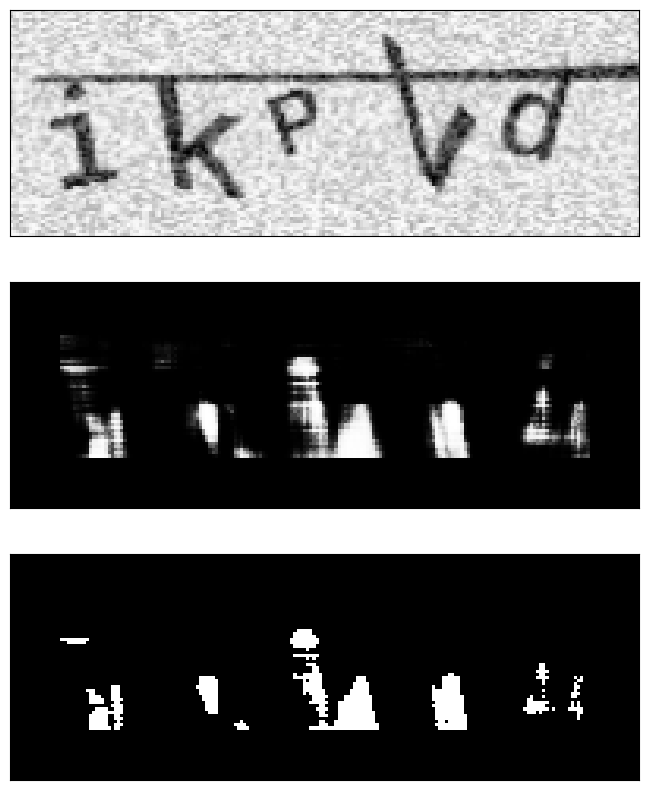

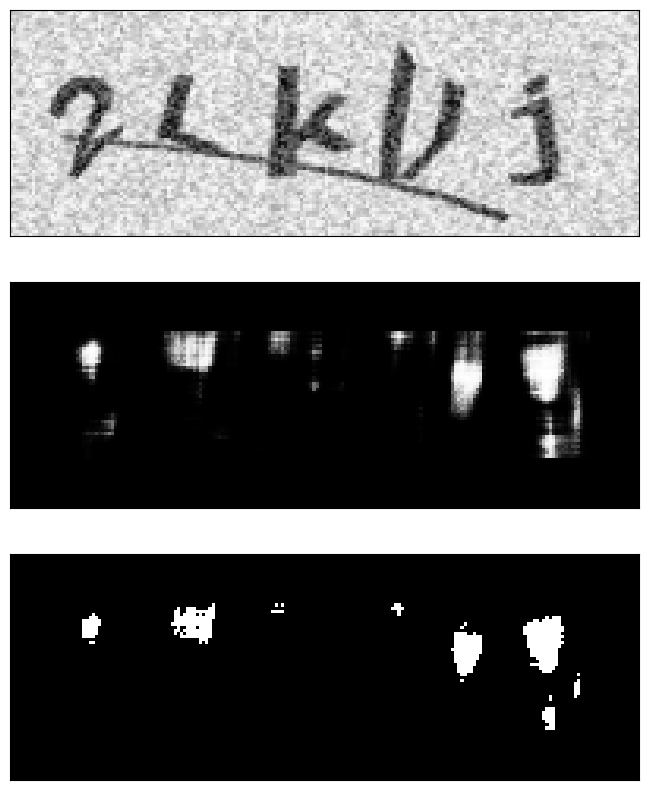

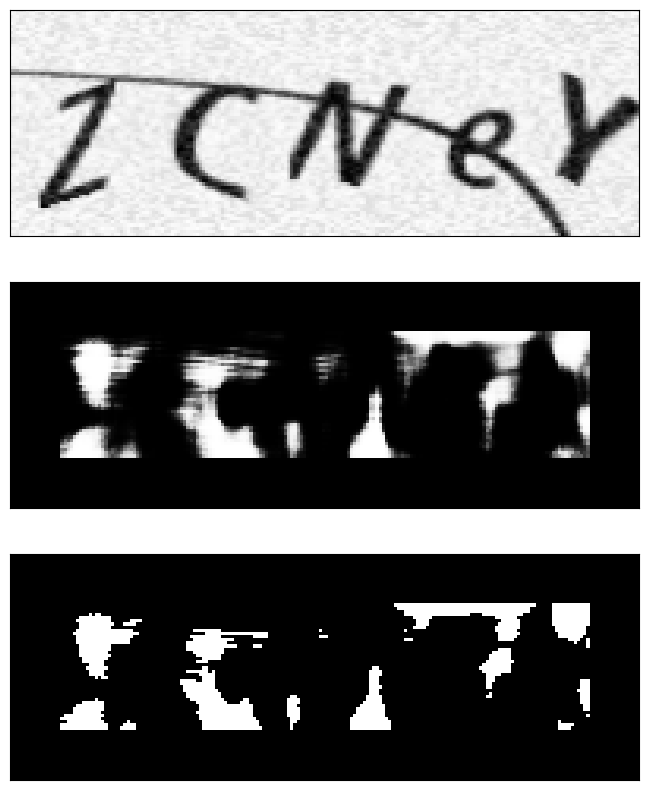

In [13]:
#Testing on multichar captcha
for i in range(5):
    idx = np.random.randint(x_multi.shape[0])
    test_img = x_multi[idx, :, :, :]
    output = segnet.predict(test_img, verbose=False)


    #Threshold, what would be sent to K-Means clustering
    output_threshold = np.where(output > 0.5, 1, 0)

    fig, axs = plt.subplots(3,1)
    fig.set_size_inches(10,10)

    data = [test_img, output, output_threshold]

    for i, ax in enumerate(axs):
        ax.imshow(data[i], cmap="Greys_r")
        ax.set_xticks([])
        ax.set_yticks([])
    
    fig.show()

In [20]:
#Processing lots of heat maps and saving for k-means development
from tqdm import tqdm
k_data = []

N = 200
for i in tqdm (range(N), desc="Generating K Means Data"):

    test_img = x_multi[i, :, :, :]
    output = segnet.predict(test_img, verbose=False)

    #Threshold, what would be sent to K-Means clustering
    output = np.squeeze(np.where(output > 0.5, 1, 0))
    
    idx_row, idx_col = np.nonzero(output)
    
    k_data.append(list(zip(idx_row,idx_col)))
    
    
    
    

Generating K Means Data: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [06:57<00:00,  2.09s/it]


# K-Means Clustering

We are using sklean.cluster

Cite this:

Scikit-learn: Machine Learning in Python, Pedregosa et al., JMLR 12, pp. 2825-2830, 2011.

In [22]:
from sklearn.cluster import MiniBatchKMeans

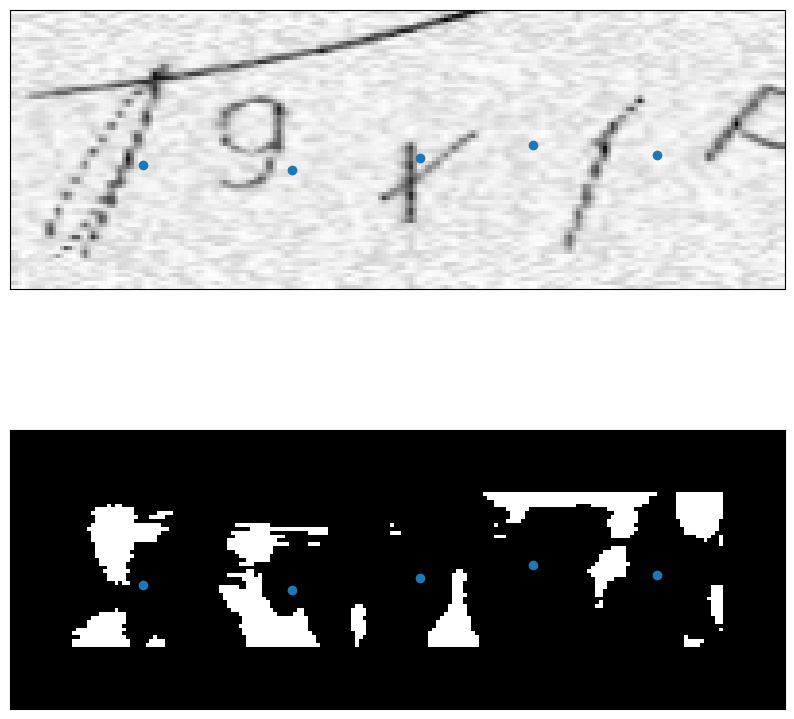

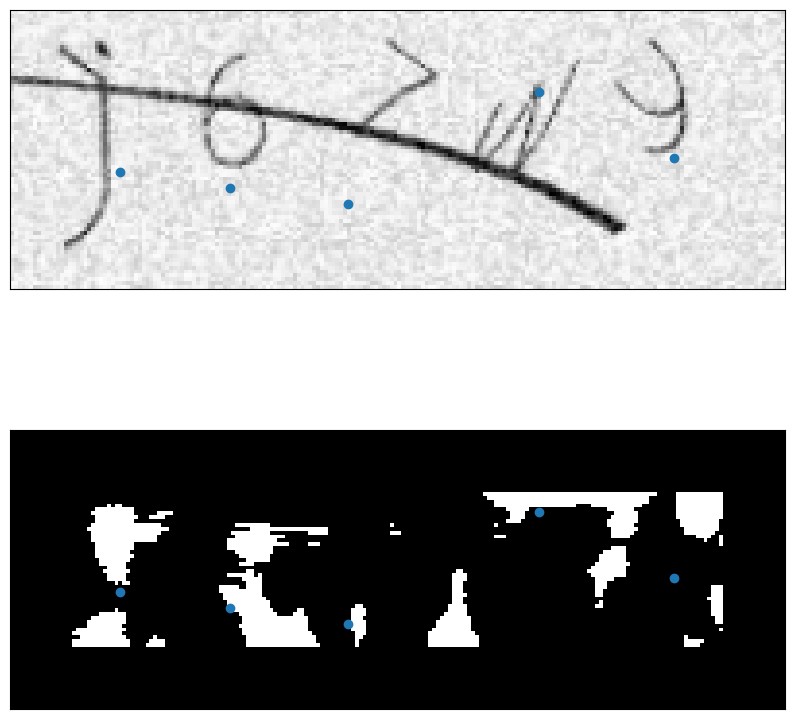

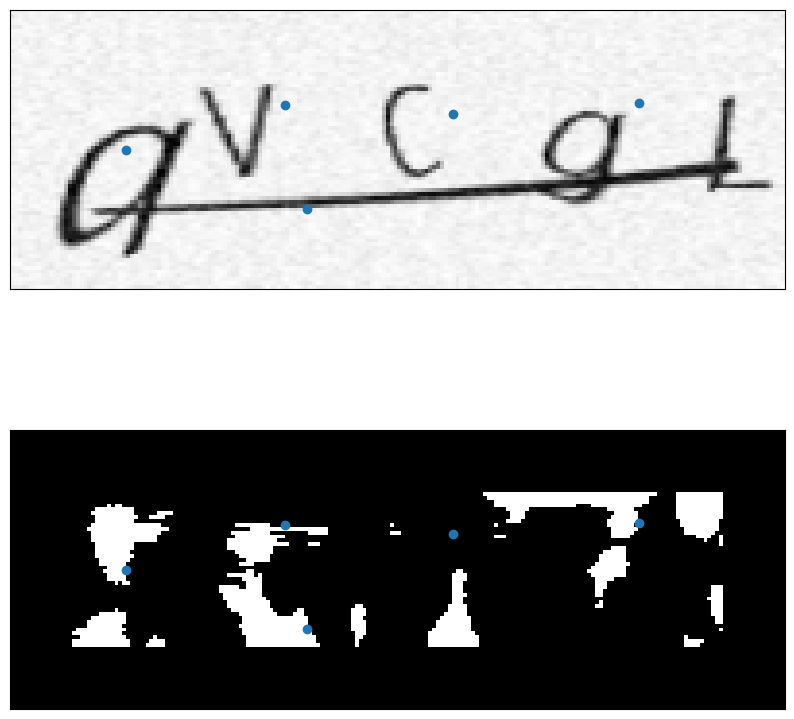

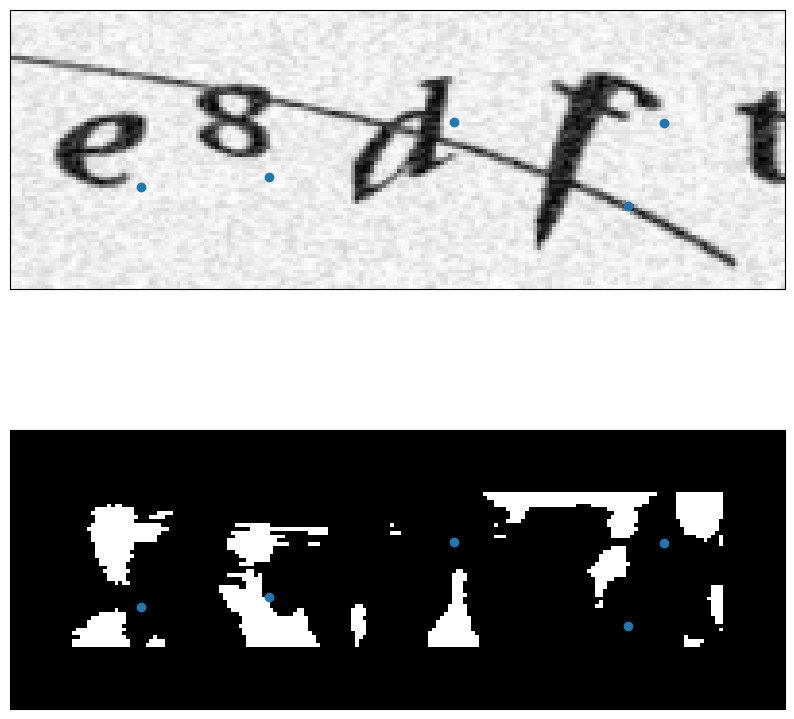

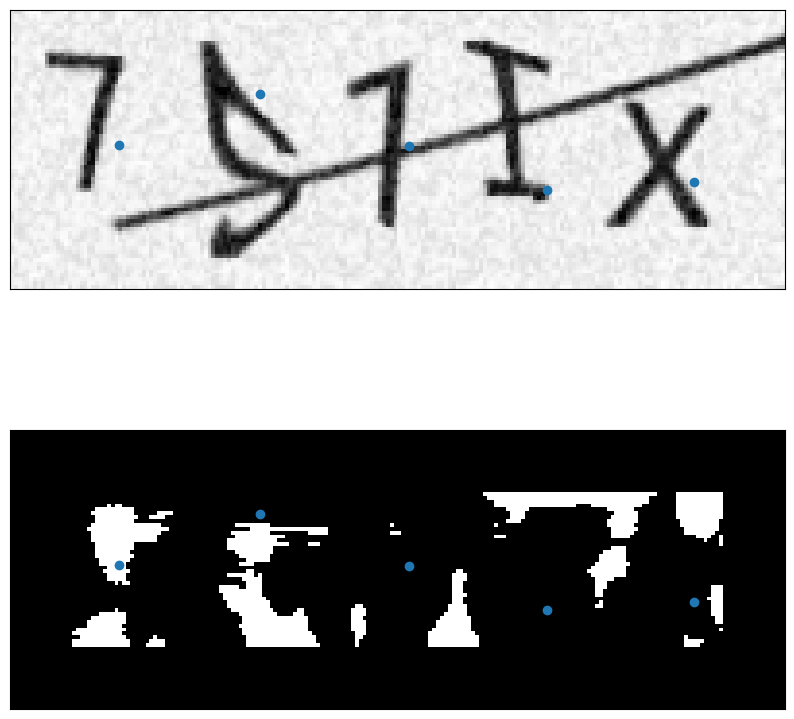

In [44]:
K = 5 #Number of chars in image

#Creating k-means object
kmeans = MiniBatchKMeans(n_clusters = K, n_init=10)

for i in range(5):
    idx = np.random.randint(len(k_data))
    kmeans.fit(k_data[idx])
    centroids = kmeans.cluster_centers_

    fig, axs = plt.subplots(2,1)
    fig.set_size_inches(10,10)

    data = [x_multi[idx,:,:,:], output_threshold]

    for i, ax in enumerate(axs):
        ax.imshow(data[i], cmap="Greys_r")
        ax.set_xticks([])
        ax.set_yticks([])

        ax.scatter(centroids[:,1], centroids[:,0])

